In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import average_precision_score,balanced_accuracy_score, auc,confusion_matrix, cohen_kappa_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, recall_score, precision_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, KFold, cross_val_score, RepeatedStratifiedKFold

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import hashlib

## 1. Load Processed Data

In [3]:
x_rus = joblib.load("../1_data/processed_data/x_rus.pkl")
y_rus = joblib.load("../1_data/processed_data/y_rus.pkl")

x_sm = joblib.load("../1_data/processed_data/x_sm.pkl")
y_sm = joblib.load("../1_data/processed_data/y_sm.pkl")

x_test = joblib.load("../1_data/processed_data/X_test.pkl")
y_test = joblib.load("../1_data/processed_data/y_test.pkl")

## 2. Create Log Template

In [4]:
def time_stamp():
    return datetime.now()

In [5]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "precision_avg" : [],
        "recall_avg" : [],
        "data_configurations" : [],
    }

    return logger

In [6]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

## 3. Baseline Model using Dummy Classifier

In [7]:
from sklearn.dummy import DummyClassifier

In [8]:
dummy_clf = DummyClassifier(strategy="uniform", random_state=1)
dummy_clf.fit(x_sm, y_sm)

DummyClassifier(random_state=1, strategy='uniform')

In [9]:
dummy_clf.score(x_sm, y_sm)

0.4985227272727273

In [10]:
dummy_clf.score(x_test,y_test)

0.5177664974619289

**Comment**:

Sebelum melakukan modelling dengan baseline model memakai algoritam tertentu, pastikan membuat baseline model paling basic.
Dummy model disini mendapatkan score akurasi 0.51 di mana jika dalam modeling kita tidak tembus dengan score 0.51 akurasi, maka model yang dibangun tidak ada gunanya.

## 4. Training and Evaluation

### Initialie Model Object

In [11]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [12]:
list_of_model = {
    "undersampling" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr_baseline.__class__.__name__, "model_object": lgr_baseline, "model_uid": ""},
        { "model_name": dct_baseline.__class__.__name__, "model_object": dct_baseline, "model_uid": ""},
        { "model_name": rfc_baseline.__class__.__name__, "model_object": rfc_baseline, "model_uid": ""},
        { "model_name": knn_baseline.__class__.__name__, "model_object": knn_baseline, "model_uid": ""},
        { "model_name": xgb_baseline.__class__.__name__, "model_object": xgb_baseline, "model_uid": ""}
        ],
    }

In [13]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["precision_avg"].append(performance["macro avg"]["precision"])
        logger["recall_avg"].append(performance["macro avg"]["recall"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model, performance

### Baseline Model Undersampling

In [14]:
training_log, list_of_model_rus, performance = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_rus,
    y_rus,
    "undersampling",
    x_test,
    y_test,
    "../5_log/training_log.json"
)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/bimapriambodo/anaconda3/envs/skuy/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/tmp/ipykernel_8569/354089643.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model["model_object"].fit(x_train, y_train)
 60%|███████████████████████████                  | 3/5 [00:00<00:00, 12.88it/s]/home/bimapriambodo/anaconda3/envs/skuy/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
100%|████████████████

In [15]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Baseline Model SMOTE

In [16]:
training_log, list_of_model_sm, performance = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_sm,
    y_sm,
    "smote",
    x_test,
    y_test,
    "../5_log/training_log.json"
)

  0%|                                                     | 0/5 [00:00<?, ?it/s]/home/bimapriambodo/anaconda3/envs/skuy/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
 40%|██████████████████                           | 2/5 [00:00<00:00, 11.18it/s]/tmp/ipykernel_8569/354089643.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model["model_object"].fit(x_train, y_train)
/home/bimapriambodo/anaconda3/envs/skuy/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
100%|████████████████

In [17]:
list_of_model["smote"] = copy.deepcopy(list_of_model_sm)

### Best Performance Baseline MOdel

In [18]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["f1_score_avg", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [19]:
training_res = training_log_to_df(training_log)

100%|████████████████████████████████████████████| 2/2 [00:00<00:00, 855.98it/s]


In [20]:
training_res

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,precision_avg,recall_avg,data_configurations
0,baseline_model-XGBClassifier,83695d31ed151f48fd07120cd62b65b6,0.692484,2022-12-04 17:17:50.305654,"{'0': {'precision': 0.976679104477612, 'recall...",0.778919,0.747430,0.823470,smote
1,baseline_model-RandomForestClassifier,c0195fe945bfd837ba7ab17991ad1943,1.148583,2022-12-04 17:17:49.098131,"{'0': {'precision': 0.9743346007604563, 'recal...",0.735735,0.698706,0.801275,smote
2,baseline_model-LogisticRegression,feb7c44f37d8e9e876104ad53c6e77fb,0.024373,2022-12-04 17:17:47.175223,"{'0': {'precision': 0.9702209414024976, 'recal...",0.700442,0.665962,0.770067,undersampling
3,baseline_model-DecisionTreeClassifier,f505269aa5dd8d3c3c9976854642a5eb,0.099767,2022-12-04 17:17:48.992926,"{'0': {'precision': 0.9718446601941747, 'recal...",0.696449,0.660264,0.778171,smote
4,baseline_model-LogisticRegression,18c6b3ccb2fd79e3953e4534bc5a79b2,0.069161,2022-12-04 17:17:48.918644,"{'0': {'precision': 0.9692603266090298, 'recal...",0.695490,0.661935,0.763514,smote
5,baseline_model-XGBClassifier,0c4cb14ee247b74c8710d3ad287070fe,0.215394,2022-12-04 17:17:47.622970,"{'0': {'precision': 0.9833679833679834, 'recal...",0.677321,0.641684,0.832439,undersampling
6,baseline_model-KNeighborsClassifier,fdf40db577c551a664b8d04c4bc8220e,0.003930,2022-12-04 17:17:50.268897,"{'0': {'precision': 0.9737638748738647, 'recal...",0.666630,0.633479,0.780100,smote
7,baseline_model-KNeighborsClassifier,e2e917bb5f227a1682c050d596428f89,0.010194,2022-12-04 17:17:47.408897,"{'0': {'precision': 0.9774193548387097, 'recal...",0.630418,0.609741,0.785133,undersampling
8,baseline_model-RandomForestClassifier,f84e2fe13536ed69d95338a94456b4e0,0.168661,2022-12-04 17:17:47.221703,"{'0': {'precision': 0.9793702497285559, 'recal...",0.629987,0.610375,0.794146,undersampling
9,baseline_model-DecisionTreeClassifier,7016107418937b5000e929571f174fda,0.006973,2022-12-04 17:17:47.209700,"{'0': {'precision': 0.9800235017626322, 'recal...",0.584858,0.588199,0.775432,undersampling


In [21]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["f1_score_avg", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object

In [22]:
model = get_best_model(training_res, list_of_model)

**COMMENT**:

Dari hasil experiment modeling di atas dengan scenario Oversampling smote, dan undersampling didapatkan SMOTE merupakan scenario terbaik. 4 top performa model ditempati oleh model dengan scenario smote.
Lalu dari sisi algoritma didapatkan XGboost mendapatkan nilai score terbaik dengan score F1 rata2 0.77 di data test. Precission Recall secara average tembus dengan nilai 0.74 dan 0.82
.
Kita coba lakukan eksperiment untuk tuning parameter XGBooost untuk meningkatkan peformanya.

## 5. Hyper Parameter Experimentations Tuning

In [273]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

In [128]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,10,2),
    'min_child_weight':range(1,10,2),
    'gamma':[i/10.0 for i in range(0,5)],
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(seed=42), 
                        param_grid = param_test1, scoring='f1', n_jobs=-1, cv=cv)

gsearch1.fit(x_sm, y_sm)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=42),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inter...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                         'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 10, 2),
                         'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='f1')

In [160]:
# help(gsearch1)

In [135]:
gsearch1.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1e-05, reg_lambda=1, ...)

In [130]:
gsearch1.best_params_, gsearch1.best_score_

({'gamma': 0.0, 'max_depth': 9, 'min_child_weight': 1, 'reg_alpha': 1e-05},
 0.9693865103241174)

In [23]:
xgb = XGBClassifier(
 max_depth=9,
 min_child_weight=1,
 gamma=0.0,
 reg_alpha=1e-05,
 seed=42)
xgb.fit(x_sm, y_sm)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1e-05, reg_lambda=1, ...)

In [24]:
def evaluate_model_testing(model,fitur_train, y_train, fitur_test, y_test):
    #test
    predY = model.predict(fitur_test)
    probs = model.predict_proba(fitur_test)
    probs = probs[:, 1]
    #train
    pred_train = model.predict(fitur_train)
    probs_train = model.predict_proba(fitur_train)
    probs_train = probs_train[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    #classification report
    print(classification_report(y_test, predY))
    
    print("Accuracy on testing :" + str(accuracy_score(y_test, predY)))
    print("AUC of ROC on Testing :" + str(roc_auc_score(y_test, predY)))
    print("AUC of ROC on Train:" + str(roc_auc_score(y_train,pred_train)))
    print("AUC of ROC on Probability Train:" + str(roc_auc_score(y_train,probs_train)))
    print("AUC of ROC on Probability Test:" + str(roc_auc_score(y_test,probs)))
    # print("AUC of Precision-Recall Curve on Testing :" + str(auc(recall, precision)))
    # print("Precision Score :" + str(precision_score(y_test, predY)))
    # print("F1 Score :" + str(f1_score(y_test, predY)))
    # print("Recall Score :" + str(recall_score(y_test, predY)))
    
    #TN EAR EDR
    (tn, fp, fn, tp ) = confusion_matrix(y_test, predY).ravel()
    print("TN :" + str(tn), "\t""FP :" + str(fp), "\t""FN :" + str(fn), "\t""TP :" + str(tp))
    # print("EAR "+str((fp+tp)/(fp+tp+tn+fn)))
    # print("EDR "+str((fp)/(fp+tp)))
    print("Recall Score no Weihted:", str(tp/(tp+fn)))
    print("Specifity Score :" + str(tn/(tn+fp)))
    
    #confusion matrix plot
    conf_mat = confusion_matrix(y_test, predY)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

In [25]:
y_test.value_counts()

class
0        1100
1          82
dtype: int64

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1100
           1       0.58      0.72      0.64        82

    accuracy                           0.94      1182
   macro avg       0.78      0.84      0.81      1182
weighted avg       0.95      0.94      0.95      1182

Accuracy on testing :0.9441624365482234
AUC of ROC on Testing :0.8402106430155211
AUC of ROC on Train:0.9998863636363636
AUC of ROC on Probability Train:0.9999999741735537
AUC of ROC on Probability Test:0.9440687361419068
TN :1057 	FP :43 	FN :23 	TP :59
Recall Score no Weihted: 0.7195121951219512
Specifity Score :0.9609090909090909


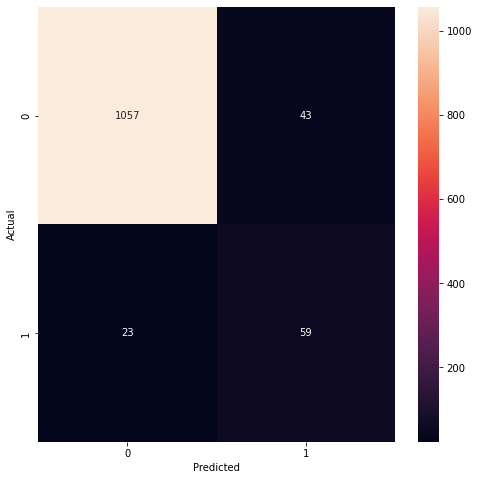

In [26]:
evaluate_model_testing(xgb,x_sm, y_sm, x_test,y_test)

**COMMENT**:

Dari hasil experiment tuning yang dilakukan didapatkan hasil:

1. F1 score 0.81 > 0.77 (model sebelumnya)
2. Recall avg 0.84 > 0.82 (model sebelumnya)
3. Precision avg 0.78 > 0.74 (model sebelumnya)

### Experimentation Variable Selections After Tuning

In [32]:
feature = pd.DataFrame()
feature['variable'] = x_sm.columns
feature['Importance'] = xgb.feature_importances_

In [33]:
feature.sort_values(by='Importance',ascending=False, inplace=True)

In [34]:
feature.head(20)

,variable,Importance
0,Attr21,0.283531
5,Attr13,0.129177
2,Attr27,0.121069
8,Attr34,0.062377
16,Attr24,0.056794
1,Attr35,0.039367
10,Attr51,0.033864
9,Attr6,0.033529
3,Attr56,0.033342
4,Attr49,0.027695


In [53]:
f1_train=[]
f1_test=[]
for i in range(x_sm.shape[1]):
    print(i)
    model_xgb = XGBClassifier(max_depth=9,
                              min_child_weight=1,
                              gamma=0.0,
                              reg_alpha=1e-05,
                              seed=42)
    model_xgb.fit(x_sm[feature.variable.to_list()].iloc[:,:i+1],
             y_sm)
    y_pred_train = model_xgb.predict(x_sm[feature.variable.to_list()].iloc[:,:i+1])
    y_pred_test = model_xgb.predict(x_test[feature.variable.to_list()].iloc[:,:i+1])
    performance_train = classification_report(y_sm, y_pred_train, output_dict = True)
    performance_test = classification_report(y_test, y_pred_test, output_dict = True)
    f1_train.append(performance_train["macro avg"]["f1-score"])
    f1_test.append(performance_test["macro avg"]["f1-score"])
    if i == 19:
        break
    del model_xgb

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


              precision    recall  f1-score   support

           0       0.95      1.00      0.97      1100
           1       0.96      0.30      0.46        82

    accuracy                           0.95      1182
   macro avg       0.96      0.65      0.72      1182
weighted avg       0.95      0.95      0.94      1182

Accuracy on testing :0.9509306260575296
AUC of ROC on Testing :0.6519844789356984
AUC of ROC on Train:0.6155681818181817
AUC of ROC on Probability Train:0.7911198088842974
AUC of ROC on Probability Test:0.7930654101995566
TN :1099 	FP :1 	FN :57 	TP :25
Recall Score no Weihted: 0.3048780487804878
Specifity Score :0.9990909090909091


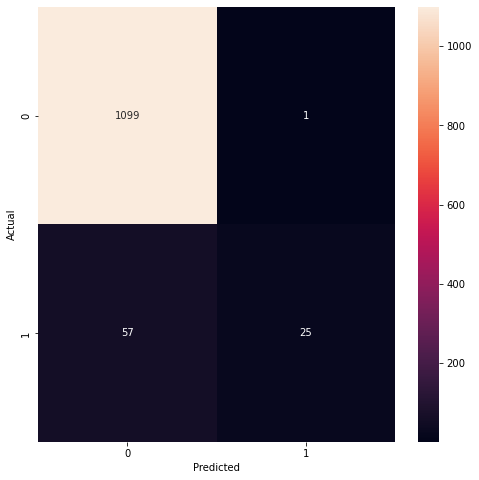

In [54]:
evaluate_model_testing(model_xgb,x_sm, y_sm, x_test,y_test)

In [48]:
len(x_sm.columns)

20

In [49]:
x_sm.shape

(8800, 20)

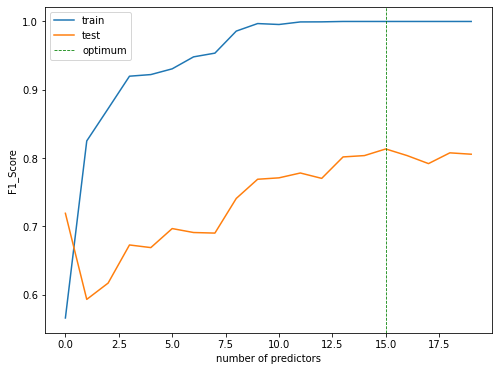

In [50]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(x_sm.shape[1]), f1_train, label="train")
ax.plot(range(x_sm.shape[1]), f1_test, label="test")
ax.axvline(
      15, 0, 1, color='g', label="optimum",
      linestyle="--", linewidth=0.8
      )
ax.legend(loc='upper left')
ax.set_xlabel('number of predictors')
ax.set_ylabel('F1_Score');

**COMMENT**:
    
Dari model yang sudah dituning, dilakukan ekserimentasi untuk memilih variable lagi.
20 variable yang telah dipilih sebelumnya bisa jadi bukan nilai optimal.
Langkah yang dilakukan:

1. Melihat nilai importance dari model tuning, dan diurutkan dari dari paling top ke bawah
2. Kita coba plot performa model saat memprediksi data train dan test dari setiap jumlah variable yang difitting ke model.

Hasilnya bahwa, 16 variable merupakan jumlah paling optimal, karena mendapat nilai score paling baik, lebih dari itu peforma data test maah turun.

In [51]:
f1_test[19]

0.805554219825219

In [43]:
f1_train[16-1]

0.9998863636348961

In [44]:
x_sm[feature.variable.to_list()].iloc[:,:15].head()

,Attr21,Attr13,Attr27,Attr34,Attr24,Attr35,Attr51,Attr6,Attr56,Attr49,Attr40,Attr55,Attr50,Attr58,Attr43
0,0.129515,-0.007583,0.255156,0.056415,0.149232,0.020572,0.020572,0.020572,-0.000772,0.044325,0.060071,0.964337,0.056415,-0.014070,-0.097285
1,0.129515,-0.013552,0.255156,0.056415,0.149232,0.020572,0.020572,0.020572,-0.131874,0.000731,0.060071,-0.124906,0.056415,0.097191,-0.110564
2,0.129515,-0.009147,0.255156,0.056415,0.149232,0.020572,0.020572,0.020572,0.129706,0.083951,0.060071,-0.105397,0.056415,-0.091788,-0.018349
3,0.129515,-0.011208,0.255156,0.056415,0.149232,0.020572,0.020572,0.020572,0.033181,0.051449,0.060071,-0.128214,0.056415,-0.022678,-0.126752
4,0.129515,-0.005787,0.255156,0.056415,0.149232,0.020572,0.020572,0.020572,0.169454,0.088773,0.060071,0.106540,0.056415,-0.158476,-0.077133


In [45]:
xgb = XGBClassifier(
 max_depth=9,
 min_child_weight=1,
 gamma=0.0,
 reg_alpha=1e-05,
 seed=42)
xgb.fit(x_sm[feature.variable.to_list()].iloc[:,:15], 
        y_sm)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=1e-05, reg_lambda=1, ...)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1100
           1       0.57      0.72      0.64        82

    accuracy                           0.94      1182
   macro avg       0.78      0.84      0.80      1182
weighted avg       0.95      0.94      0.95      1182

Accuracy on testing :0.94331641285956
AUC of ROC on Testing :0.8397560975609756
AUC of ROC on Train:0.9998863636363636
AUC of ROC on Probability Train:0.9999999741735537
AUC of ROC on Probability Test:0.9405543237250554
TN :1056 	FP :44 	FN :23 	TP :59
Recall Score no Weihted: 0.7195121951219512
Specifity Score :0.96


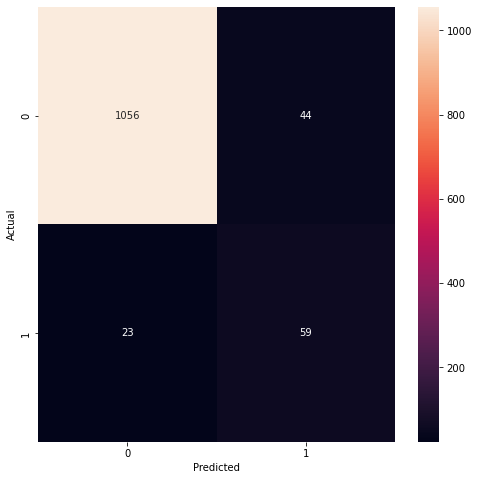

In [46]:
evaluate_model_testing(xgb,
                       x_sm[feature.variable.to_list()].iloc[:,:15], 
                       y_sm, 
                       x_test[feature.variable.to_list()].iloc[:,:15],
                       y_test)

**COMMENT**:

16 Variable utama dimodelkan lagi, dan mendapatkan nilai metrics:

1. F1 score 0.80 < 0.81 (model sebelumnya)
2. Recall avg 0.84 == 0.84 (model sebelumnya)
3. Precision avg 0.78 == 0.78  (model sebelumnya)

Terlihat cenderung tidak ada perubahan, F1 score turun 0.01.
Namun kabar baiknya, model menjadi lebih simple dan komputasi lebih ringan, karena dari 20 variable menjadi 16 variable. Dengan variable lebih sedikit namun peforma cenderung sama.

Ada istilah curse dimensionality in machine learning, Curse of Dimensionality describes the explosive nature of increasing data dimensions and its resulting exponential increase in computational efforts required for its processing and/or analysis.

In [292]:
import joblib

joblib.dump(xgb, "../4_models/xgb_notebook.pkl")